In [1]:
import sys
sys.path.append("/s/ls4/users/grartem/RL_robots/continuous-grid-arctic/src")
sys.path.append("/s/ls4/users/grartem/RL_robots/RL_robotSim/")
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
os.chdir("/s/ls4/users/grartem/RL_robots/RL_robotSim/")

In [3]:
import time
import gym
import pyhocon
import numpy as np
import pandas as pd
import ray
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ddpg.td3 import TD3Trainer
import pygame
import matplotlib.pyplot as plt
import MyTfModel
import MyNewModels
%matplotlib inline

import MyMisc

pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Prepare env and model

In [10]:
configs = pyhocon.ConfigFactory.parse_file("/s/ls4/users/grartem/RL_robots/RL_robotSim/Configs/FollowerContinuous/PPO_dyn_obst_2.conf")
#CONFIG = configs["ppo_e28_b1_f14v2_prev5_m_trans_v4v2"].as_plain_ordered_dict()
CONFIG = configs["ppo_e30_f1v2_t5v7"].as_plain_ordered_dict()
CONFIG["config"]["num_workers"]=1

In [11]:
EXPERIMENT_DIR = "/s/ls4/users/grartem/RL_robots/RL_robotSim/results/FollowerContinuous_Prev/e30/PPO/ppo_e30_t5v7/PPO_continuous-grid_3a1e4_00000_0_2023-09-13_05-57-08/"
checkpoint_path = EXPERIMENT_DIR + "/checkpoint_000100/checkpoint-100"


In [12]:
CONFIG["config"]["env_config"]["base_env_config"]

OrderedDict([('game_width', 1500),
             ('game_height', 1000),
             ('pixels_to_meter', 10),
             ('step_grid', 10),
             ('max_steps', 30000),
             ('framerate', 5000),
             ('random_frames_per_step', [30, 70]),
             ('min_distance', 8),
             ('max_distance', 15),
             ('max_dev', 1),
             ('constant_follower_speed', False),
             ('warm_start', 0),
             ('ignore_follower_collisions', False),
             ('path_finding_iterations', 15000),
             ('follower_size', [1, 1]),
             ('leader_size', [4, 2]),
             ('bear_size', [1.5, 1.5]),
             ('leader_max_speed', 1),
             ('follower_max_speed', 2),
             ('negative_speed', True),
             ('bear_max_speed', 1.2),
             ('follower_max_rotation_speed', 28.65),
             ('leader_max_rotation_speed', 28.65),
             ('follower_acceleration', 1),
             ('leader_acceleration', 1)

In [13]:
trainer = ray.rllib.agents.registry.get_trainer_class(CONFIG["run"])(CONFIG["config"])
#trainer = ray.rllib.agents.registry.get_trainer_class("PPO")(CONFIG)
#trainer.restore(checkpoint_path)

env = MyMisc.continuous_env_maker(config=CONFIG["config"]["env_config"])
#env = MyMisc.continuous_env_maker(config=CONFIG["env_config"])

(RolloutWorker pid=3362) pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
(RolloutWorker pid=3362) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=3362) ===Запуск симуляции номер 0===


(RolloutWorker pid=3362) /s/ls4/users/grartem/RL_robots/continuous_grid_arctic/src/continuous_grid_arctic/follow_the_leader_continuous_env.py:385: UserWarning: Одновременно заданы и random_frames_per_step и frames_per_step, будет использоваться random_frames_per_step
(RolloutWorker pid=3362)   warn(
(RolloutWorker pid=3362) /s/ls4/users/grartem/anaconda3/envs/rl_robots/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3362)   logger.warn(
(RolloutWorker pid=3362) Failed to create secure directory (/run/user/1556/pulse): No such file or directory
(RolloutWorker pid=3362) ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
(RolloutWorker pid=3362) ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
(RolloutWorker pid=3362) ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
(RolloutWorker pid=3362) ALSA lib conf.c:456

(RolloutWorker pid=3362) sample_collector_class <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector'>


In [14]:
policy = trainer.get_policy()
print(type(policy))
print(type(policy.model))

<class 'ray.rllib.agents.ppo.ppo_torch_policy.PPOTorchPolicy'>
<class 'ray.rllib.models.torch.fcnet.FullyConnectedNetwork'>


In [15]:
policy.model

FullyConnectedNetwork(
  (_logits): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=360, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=360, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

# Test episode

In [9]:
# Start env episode
seed_i = 194
env.seed(seed_i)
obs = env.reset()
done = False
total_reward = 0.0

===Запуск симуляции номер 0===
===Запуск симуляции номер 1===
===Запуск симуляции номер 2===


In [12]:
# run N steps
NNobs_history, raw_obs_history, reward_history, info_history, actions_hist = [], [], [], [], []
obs_history = []
start_time = time.time()
for i in range(10):
    # Compute a single action, given the current observation
    # from the environment.
    NNobs_history.append(obs)
    raw_obs = env.env.env.env._get_obs()
    raw_obs_history.append({
        #'LeaderTrackDetector_radar': raw_obs['LeaderTrackDetector_radar'],
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        #'LeaderCorridor_lasers': raw_obs['LeaderCorridor_lasers']
        "numerical_features": raw_obs["numerical_features"]
    })
    
    pred_result = trainer.compute_single_action(obs, explore=False, full_fetch=True)
    action = pred_result[0]
    # Apply the computed action in the environment.
    #obs, reward, done, info = env.step(action)
    obs, reward, done, info = env.step(action)
    obs_history.append(obs)
    
    actions_hist.append(action)
    reward_history.append(reward)
    info_history.append(info)
    # Sum up rewards for reporting purposes.
    total_reward += reward
    if done:
        break
elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(elapsed_time)
#1:19

00:00:02


In [13]:
import joblib
raw_obs_history_new = joblib.dump(raw_obs_history, "raw_obs_history.joblib")
NNobs_history_new = joblib.dump(NNobs_history, "NNobs_history.joblib")

In [18]:
!pwd

/s/ls4/users/grartem/RL_robots/RL_robotSim


In [17]:

raw_obs_history_old = joblib.load("raw_obs_history.old")
NNobs_history_old = joblib.load("NNobs_history.old")

In [19]:
np.save("feat_matrix", obs)

In [24]:
obs.shape

(5, 36)

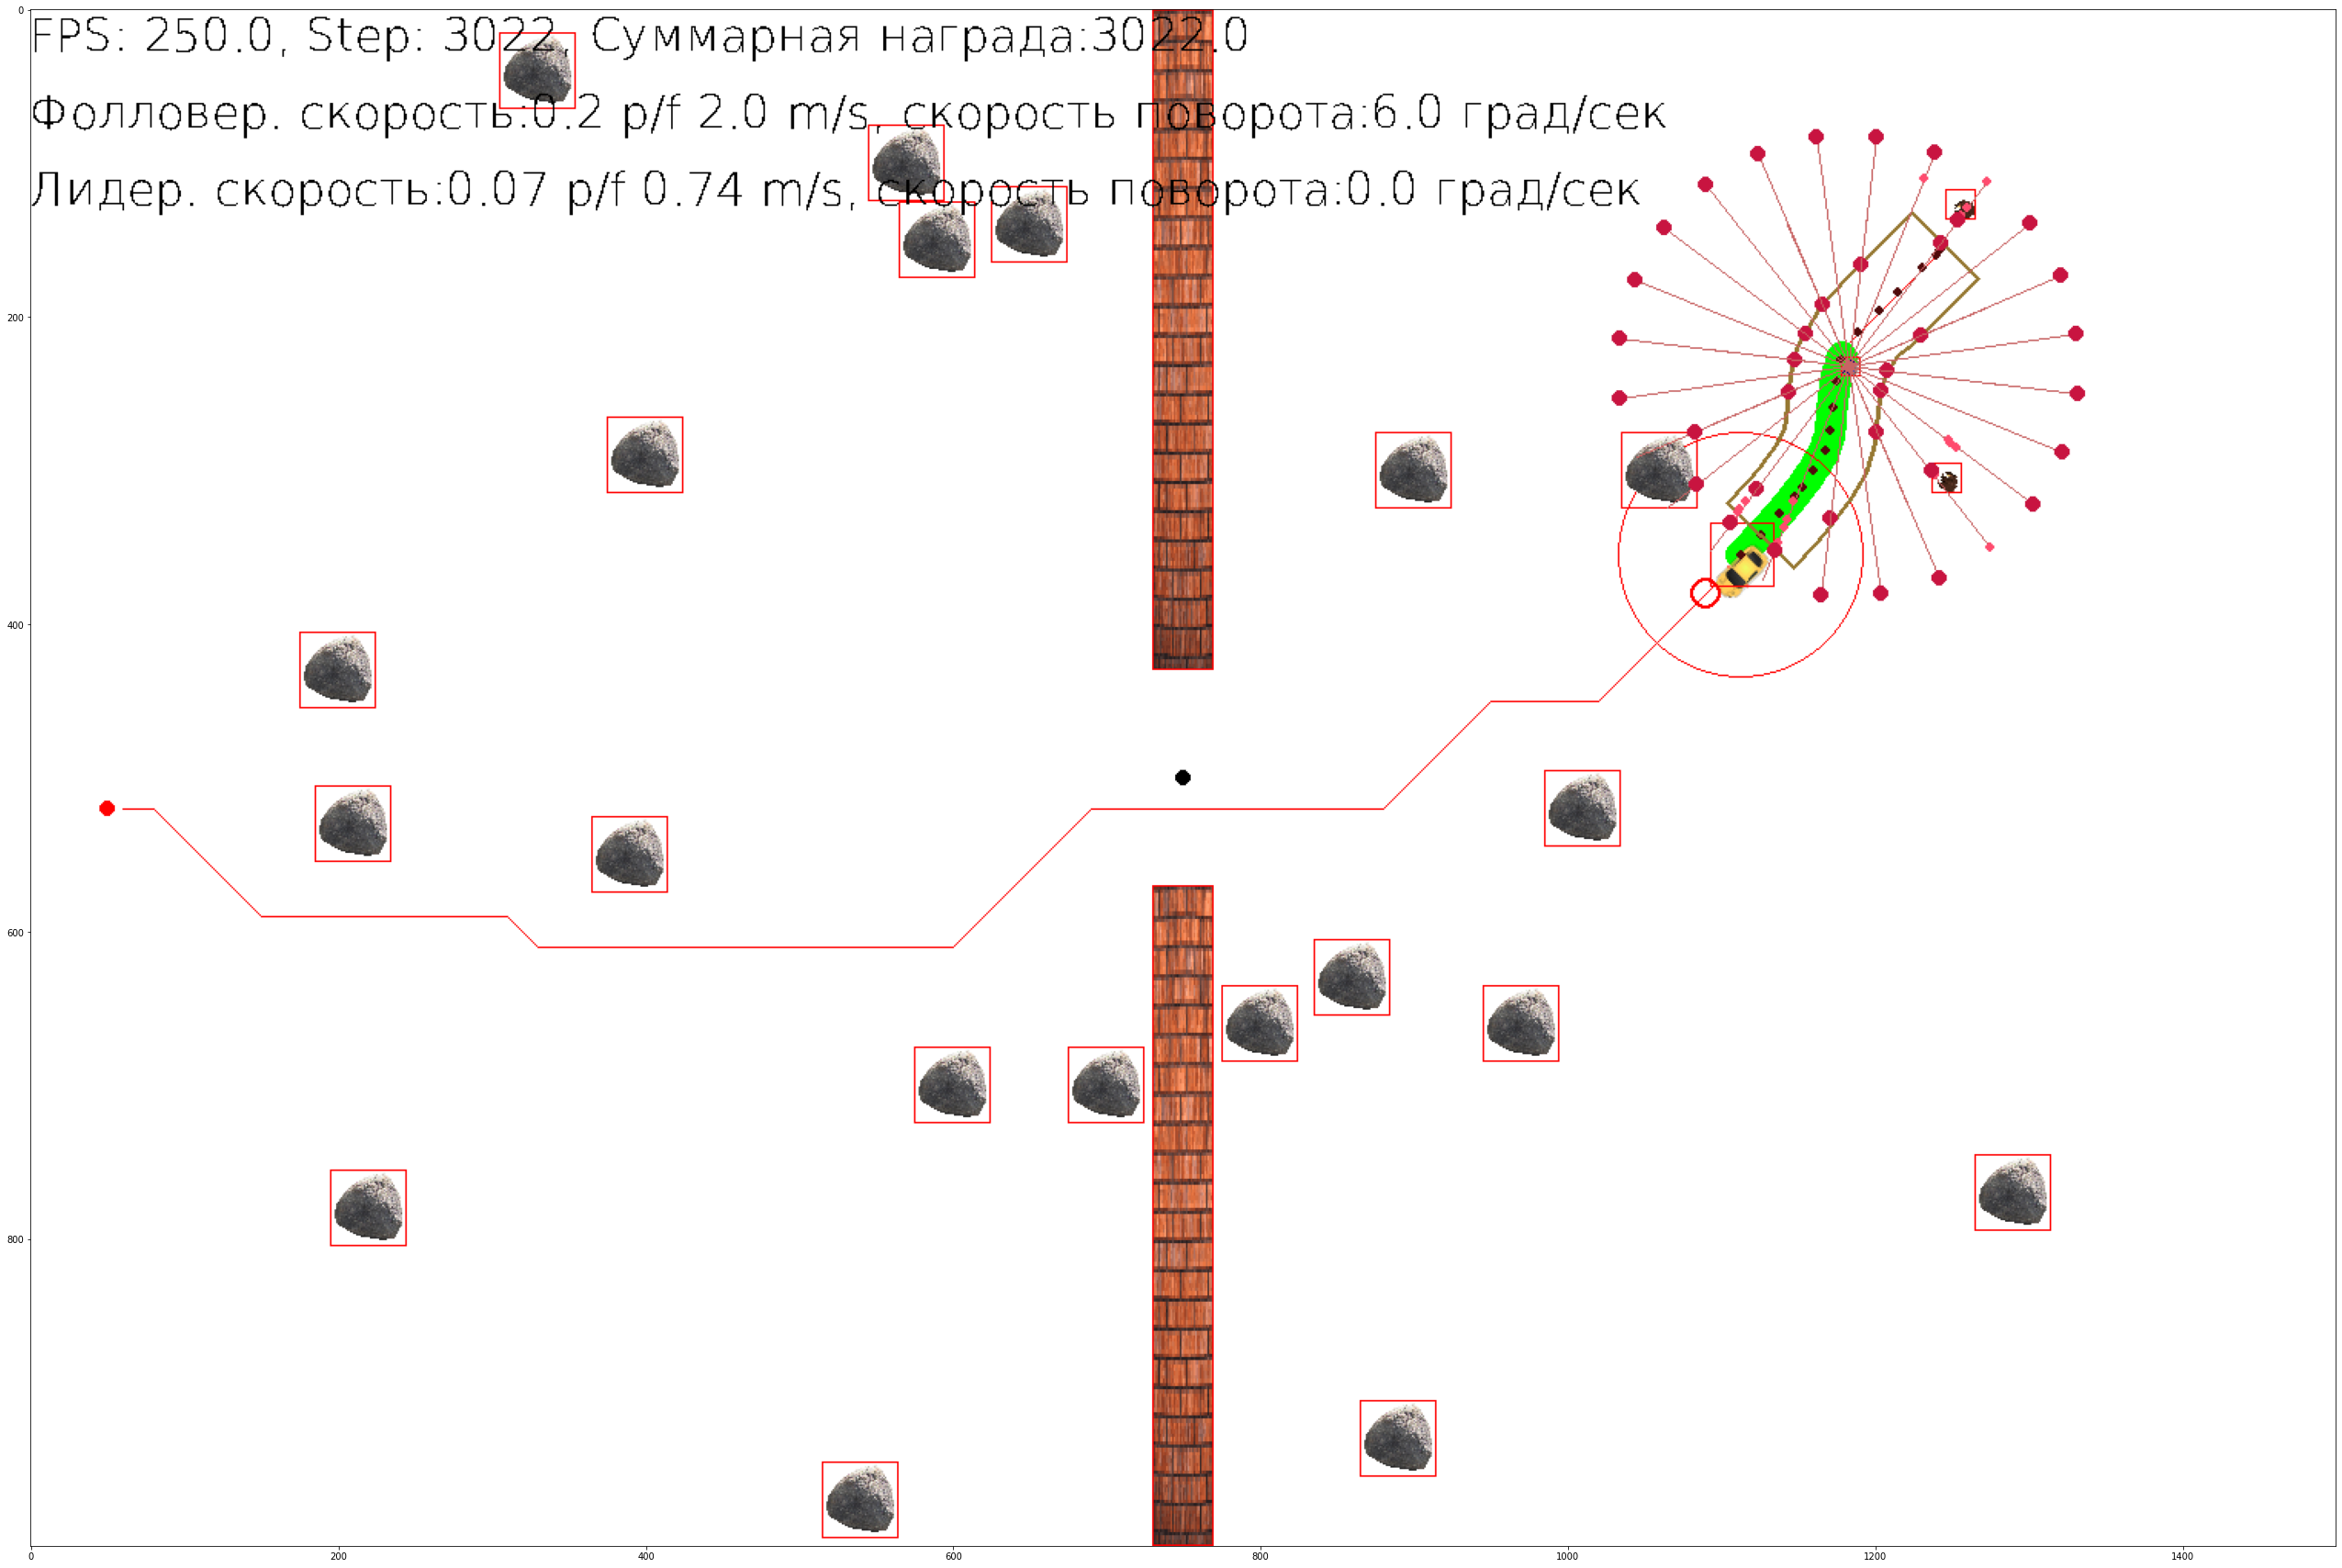

In [23]:
env.render()
plt.figure(figsize=(45,35))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

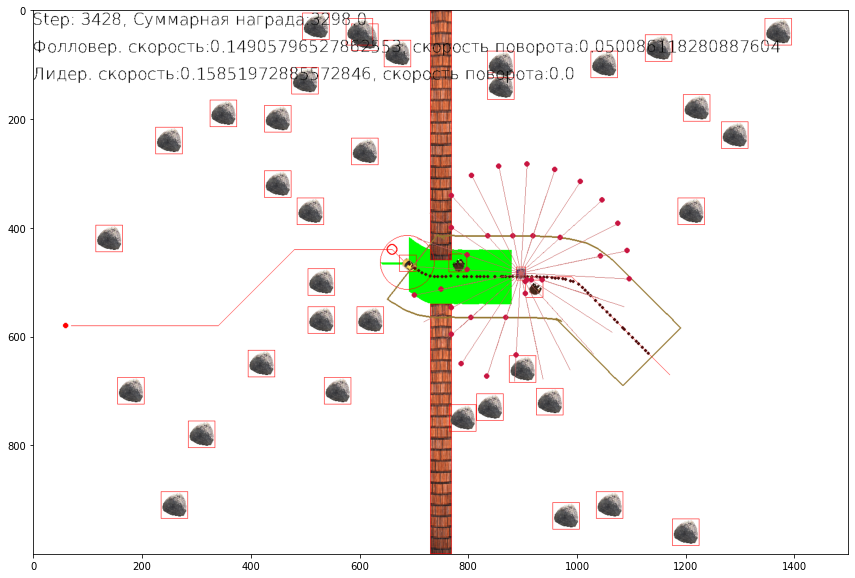

In [32]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))

In [169]:
env.follower.rectangle.center, env.follower.position, env.env.env.game_dynamic_list[0].rectangle.center, env.env.env.game_dynamic_list[0].position

((1345, 743), array([1012.,  680.]), (1040, 530), (1340.0, 530.0))

In [ ]:
env.follower.rectangle.move()

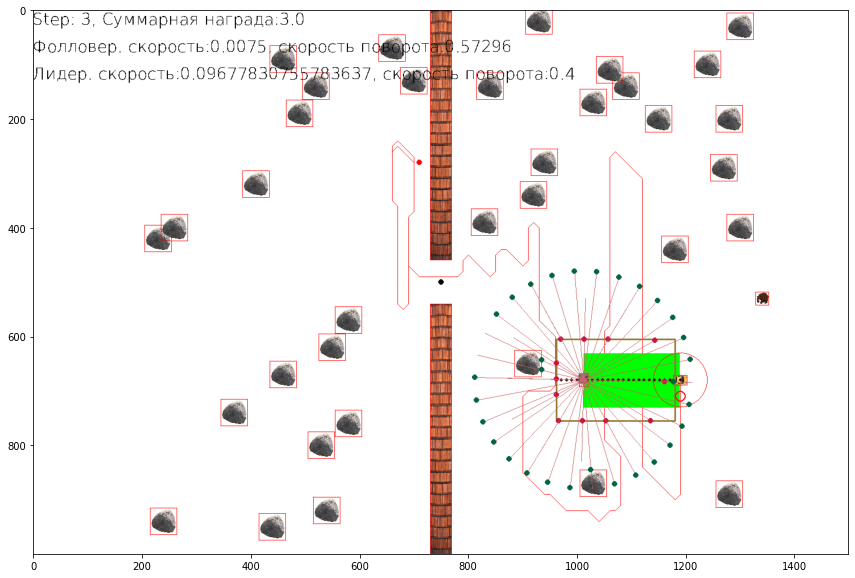

In [14]:
env.render()
plt.figure(figsize=(15,10))
plt.imshow(pygame.surfarray.array3d(env.gameDisplay).transpose((1,0,2)))